In [27]:
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set_palette("Set1")
sns.set_context('talk')

log_dir = "logs/"
fig_dir = "figures/"

# Plots Plain DQN

In [36]:
# Load in DQN logs
dqn_capacity_100 = pd.read_csv(log_dir + "dqn_capacity_100.csv")
dqn_capacity_1000 = pd.read_csv(log_dir + "dqn_capacity_1000.csv")
dqn_capacity_5000 = pd.read_csv(log_dir + "dqn_capacity_5000.csv")

dqn_batchsize_32 = pd.read_csv(log_dir + "dqn_batchsize_32.csv")
dqn_batchsize_64 = pd.read_csv(log_dir + "dqn_batchsize_64.csv")
#dqn_batchsize_128 = pd.read_csv(log_dir + "dqn_batchsize_128.csv")

#dqn_lrate_1e3 = pd.read_csv(log_dir + "dqn_lrate_1e3.csv")
dqn_lrate_1e4 = pd.read_csv(log_dir + "dqn_lrate_1e4.csv")
dqn_lrate_1e5 = pd.read_csv(log_dir + "dqn_lrate_1e5.csv")

dqn_hard_update_1 = pd.read_csv(log_dir + "dqn_hard_update_1.csv")
dqn_hard_update_100 = pd.read_csv(log_dir + "dqn_hard_update_100.csv")
dqn_soft_update_001 = pd.read_csv(log_dir + "dqn_soft_update_001.csv")
dqn_soft_update_005 = pd.read_csv(log_dir + "dqn_soft_update_005.csv")

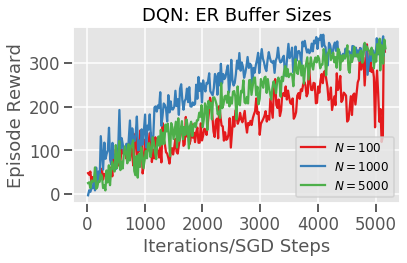

In [45]:
# Capacity Plot
plt.plot(dqn_capacity_100.loc[:, "opt_counter"], dqn_capacity_100.loc[:, "rew_mean"], label=r"$N=100$")
plt.plot(dqn_capacity_1000.loc[:, "opt_counter"], dqn_capacity_1000.loc[:, "rew_mean"], label=r"$N=1000$")
plt.plot(dqn_capacity_5000.loc[:, "opt_counter"], dqn_capacity_5000.loc[:, "rew_mean"], label=r"$N=5000$")
plt.xlabel("Iterations/SGD Steps")
plt.ylabel("Episode Reward")
plt.legend(fontsize=12)
plt.title("DQN: ER Buffer Sizes")
plt.tight_layout()
plt.savefig(fig_dir + "dqn_buffer.png", dpi=300)

Text(0.5, 1.0, 'DQN: Comparison of Batchsizes')

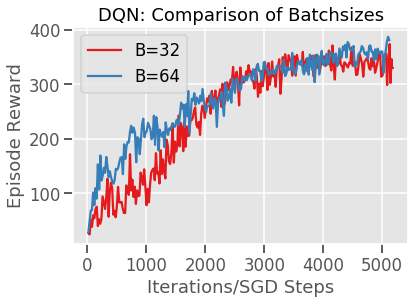

In [24]:
# Batchsize Plot
plt.plot(dqn_batchsize_32.loc[:, "opt_counter"], dqn_batchsize_32.loc[:, "rew_mean"], label=r"$B=32$")
plt.plot(dqn_batchsize_64.loc[:, "opt_counter"], dqn_batchsize_64.loc[:, "rew_mean"], label=r"$B=64$")
#plt.plot(dqn_batchsize_128.loc[:, "opt_counter"], dqn_capacity_5000.loc[:, "rew_mean"], label=r"$B=128$")
plt.xlabel("Iterations/SGD Steps")
plt.ylabel("Episode Reward")
plt.legend(fontsize=12)
plt.title("DQN: Batchsizes")
plt.tight_layout()
plt.savefig(fig_dir + "dqn_batchsize.png", dpi=300)

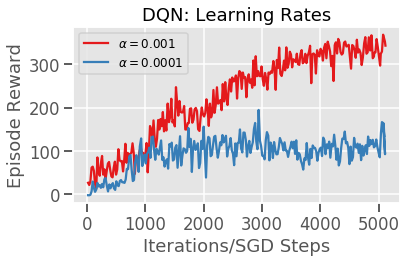

In [43]:
# Learning rate Plot
#plt.plot(dqn_lrate_1e3.loc[:, "opt_counter"], dqn_lrate_1e3.loc[:, "rew_mean"], label=r"$\alpha = 0.01$")
plt.plot(dqn_lrate_1e4.loc[:, "opt_counter"], dqn_lrate_1e4.loc[:, "rew_mean"], label=r"$\alpha = 0.001$")
plt.plot(dqn_lrate_1e5.loc[:, "opt_counter"], dqn_lrate_1e5.loc[:, "rew_mean"], label=r"$\alpha = 0.0001$")
plt.xlabel("Iterations/SGD Steps")
plt.ylabel("Episode Reward")
plt.legend(fontsize=12)
plt.title("DQN: Learning Rates")
plt.tight_layout()
plt.savefig(fig_dir + "dqn_lrate.png", dpi=300)

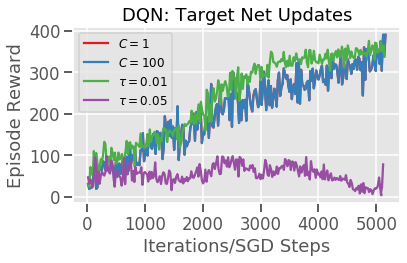

In [42]:
# Soft vs Hard updates
plt.plot(dqn_hard_update_1.loc[:, "opt_counter"], dqn_hard_update_1.loc[:, "rew_mean"], label=r"$C = 1$")
plt.plot(dqn_hard_update_1.loc[:, "opt_counter"], dqn_hard_update_1.loc[:, "rew_mean"], label=r"$C = 100$")
plt.plot(dqn_soft_update_001.loc[:, "opt_counter"], dqn_soft_update_001.loc[:, "rew_mean"], label=r"$\tau = 0.01$")
plt.plot(dqn_soft_update_005.loc[:, "opt_counter"], dqn_soft_update_005.loc[:, "rew_mean"], label=r"$\tau = 0.05$")
plt.xlabel("Iterations/SGD Steps")
plt.ylabel("Episode Reward")
plt.legend(fontsize=12)
plt.title("DQN: Target Net Updates")
plt.tight_layout()
plt.savefig(fig_dir + "dqn_target_update.png", dpi=300)

# Plots Double DQN

In [44]:
# Load in Double DQN Logs
ddqn_soft_update_001 = pd.read_csv(log_dir + "ddqn_soft_update_001.csv")
ddqn_soft_update_005 = pd.read_csv(log_dir + "ddqn_soft_update_005.csv")
ddqn_soft_update_01 = pd.read_csv(log_dir + "ddqn_soft_update_01.csv")

ddqn_gamma_09 = pd.read_csv(log_dir + "ddqn_gamma_09.csv")
ddqn_gamma_095 = pd.read_csv(log_dir + "ddqn_gamma_095.csv")
ddqn_gamma_099 = pd.read_csv(log_dir + "ddqn_gamma_099.csv")

FileNotFoundError: [Errno 2] File b'logs/ddqn_soft_update_005.csv' does not exist: b'logs/ddqn_soft_update_005.csv'

# Plots Prioritized ER DQN

# Plots Dueling DQN